# Quantum Hamiltonian Learning: Nitrogen Vacancies in Diamond

After all dependencies are met, this jupyter notebook should be runnable from top to bottom with no necessary intervention by selecting *Cell>Run All*. You may want to adjust the settings in the `Parallel Setup` section below. This entire notebook takes us about 3 hours to run on a computer with dual Xeon X5670 CPUs with a total of 12 physical cores.

### Import Modules

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('default', category=DeprecationWarning, module='.*/qinfer/.*')
from __future__ import division # Ensures that a/b is always a float.

In [2]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import qinfer as qi
from models import RabiRamseyModel, ReferencedPoissonModel
import models as m
import numpy.lib.recfunctions as rfn
import scipy.io as sio
from scipy.special import gammaln, xlogy, erf, erfinv
from scipy.misc import logsumexp
from scipy.signal import find_peaks_cwt
from scipy.optimize import curve_fit
from scipy.stats import chi2
from datetime import datetime
import os

### Setup

In [3]:
np.random.seed(1234)

#### Plotting

Plotting and exporting. Change the `overwrite` flag if you want regenerated figures to be saved to disk.

In [4]:
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

SIZE = 14
plt.rc('font', size=SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SIZE)     # fontsize of the x any y labels
plt.rc('xtick', labelsize=10)      # fontsize of the tick labels
plt.rc('ytick', labelsize=10)      # fontsize of the tick labels
plt.rc('legend', fontsize=SIZE)    # legend fontsize
plt.rc('figure', titlesize=SIZE)   # size of the figure title

overwrite = True
def export_figure(fig, name, extensions=['.png', '.pdf']):
    for ext in extensions:
        fname = '../fig/' + name + ext
        if not os.path.isfile(fname):
            print('Saving {}'.format(fname))
            fig.savefig(fname)
        elif overwrite:
            print('Overwriting {}'.format(fname))
            fig.savefig(fname)
        else:
            print('Skipping {}'.format(fname))

#### Parallel Setup

The speedup is near linear with the number of physical CPU cores used. Set parallel to True if you have an ipyparallel cluster available. You might need to change the argument of `Client()` to match your non-default profile.

In [5]:
parallel=True
if parallel:
    from ipyparallel import Client
    import os
    rc = Client()
    dview = rc[:]
    dview.use_dill()

    dview.execute('os.chdir("{}")'.format(os.getcwd()))
    dview.execute('import os')
    dview.execute('import qinfer as qi')
    dview.execute('import models')
    
    print "Engines connected: {}".format(len(rc.ids))

Engines connected: 14


In [6]:
if parallel:
    assert(dview.map_sync(lambda x: models.RabiRamseyModel, [True]) is not None)

#### Test RabiRamseyModel for bugs

In [7]:
import qinfer.tests as qit
test_eps = rfn.merge_arrays([
    np.linspace(0, 1, 10, dtype=[('t','float')]),
    np.linspace(0, 4,10, dtype=[('tau','float')]),
    np.linspace(0, 2*np.pi, 10, dtype=[('phi','float')]),
    (np.random.normal(size=10)>0).astype([('emode','int')])
])
test_prior = qi.UniformDistribution(np.array([
            [9,11], [10,12], [-1,1], [1.5,3.5], [0.5,5], [9,11]             
        ]))
test_model = RabiRamseyModel()
qit.test_model(test_model, test_prior, test_eps)

.......
----------------------------------------------------------------------
Ran 7 tests in 1.914s

OK


In [8]:
import qinfer.tests as qit
test_eps = rfn.merge_arrays([
    np.linspace(0,1,10, dtype=[('t','float')]),
    np.linspace(0,4,10, dtype=[('tau','float')]),
    np.linspace(0,2*np.pi,10, dtype=[('phi','float')]),
    (np.random.normal(size=10)>0).astype([('emode','int')]),
    np.array([0,1,2,0,1,2,0,1,2,2]).astype([('mode','int')])
])
test_prior = qi.ProductDistribution(
        qi.UniformDistribution(np.array([
            [9,11], [10,12], [-1,1], [1.5,3.5], [0.5,5], [9,11]             
        ])),
        qi.GammaDistribution(mean=10000,var=1000),
        qi.GammaDistribution(mean=3000,var=300)
    )
test_model = ReferencedPoissonModel(RabiRamseyModel())
qit.test_model(test_model, test_prior, test_eps)

.......
----------------------------------------------------------------------
Ran 7 tests in 0.584s

OK


### Load Data from Disk

#### Experiment Information

Details about the experiment are stored in a JSON file. The keys mean:
 - `center_freq`: (Hz) Center frequency of microwave circuit (synthesizer+intermediate freq)
 - `dark_idx`: Column index of dark counts (1 indexed)
 - `bright_idx`: Column index of bright counts (1 indexed)
 - `signal_idx`: Column index of dark counts (1 indexed)
 - `filename`: GLOB description of matlab data files. There is one file for every average
 - `matlab_variable`: Variable name of data in .mat file
 - `motor_position`: Unused for these experiments
 - `n_avgs`: Number of averages experiment was told to perform (this could have been manually truncated by experimentalist)
 - `n_shots`: Number of back-to-back repetitions of each experiment per average
 - `rabi_guess`: Unused for these experiments
 - `rabi_times`: (s) Pulse lengths of each Rabi experiment
 - `ramsey_times`: (s) Wait periods of each Ramsey experiment
 - `t_pulse`: (s) Length of tip pulse in Ramsey experiment
 - `static_field`: Unused for these experiments
 - `uwave_dB`: dB of pulses relative to maximum power (0dB is max, -6dB is quarter power; half amplitude, etc)

In [9]:
import json
with open('../data/rabi-ramsey-data1/notes.txt') as data_file:    
    exp_data = json.load(data_file)
rabi_times = 1e6 * eval(exp_data['RABI']['rabi_times'])
ramsey_times = 1e6 * eval(exp_data['RAMSEY']['ramsey_times'])
exp_data

{u'RABI': {u'bright_idx': 1,
  u'center_freq': 2870000000.0,
  u'dark_idx': 2,
  u'filename': u'rabi_data/Avg{:03d}.mat',
  u'matlab_variable': u'M',
  u'motor_pos': [0, 0, 0],
  u'n_avgs': 350,
  u'n_shots': 30000,
  u'rabi_guess': 5600000.0,
  u'rabi_times': u'np.linspace(8e-9,800e-9,100)',
  u'signal_idx': 3,
  u'static_field': [0, 0, 0],
  u'uwave_dB': 0},
 u'RAMSEY': {u'bright_idx': 1,
  u'center_freq': 2870000000.0,
  u'dark_idx': 2,
  u'filename': u'ramsey_data/Avg{:03d}.mat',
  u'matlab_variable': u'M',
  u'motor_pos': [0, 0, 0],
  u'n_avgs': 400,
  u'n_shots': 30000,
  u'rabi_guess': 5600000.0,
  u'ramsey_times': u'np.linspace(10e-9,2e-6,200)',
  u'signal_idx': 3,
  u'static_field': [0, 0, 0],
  u't_pulse': 4.4e-08,
  u'uwave_dB': 0}}

#### Raw Counts Data Import

Here we load the data from file. This is also where we specify that the data is to be batched into ten chronological groups. Note that successive averages (the \*.mat files) happen chronologically, with at most a minute of delay between them.

In [10]:
#only load up until the 400th average to make a nice round number
rabi_data = m.load_averages('../data/rabi-ramsey-data1/rabi_data/*.mat',[])[:400,...]
ramsey_data = m.load_averages('../data/rabi-ramsey-data1/ramsey_data/*.mat',[])[:400,...]
def batch_data(data, n_batch):
    sh = data.shape
    assert(np.mod(sh[0]/n_batch,1)==0)
    return np.sum(data.reshape((n_batch, int(sh[0]/n_batch)) + sh[1:]), axis=1)

n_batch = 10
rabi_data = batch_data(rabi_data, n_batch)
ramsey_data = batch_data(ramsey_data, n_batch)
idx_bright, idx_dark, idx_sig = 0,1,2

ramsey_bright_refs = ramsey_data[:,:,idx_bright]
ramsey_dark_refs = ramsey_data[:,:,idx_dark]
rabi_bright_refs = rabi_data[:,:,idx_bright]
rabi_dark_refs = rabi_data[:,:,idx_dark]

n_rabi = rabi_data.shape[1]
n_ramsey = ramsey_data.shape[1]

#### Raw Data Plots

Overwriting ../fig/rabi_raw_data.png
Overwriting ../fig/rabi_raw_data.pdf


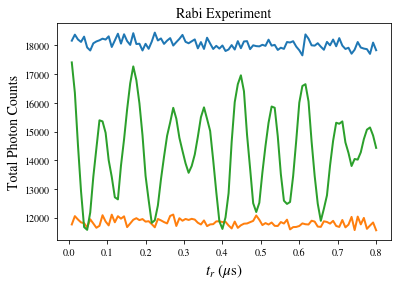

In [11]:
fig = plt.figure()
plt.plot(rabi_times, np.sum(rabi_data,axis=0),lw=2)
plt.xlabel(r'$t_r$ $(\mu $s$)$', size=15)
plt.ylabel('Total Photon Counts')
plt.title('Rabi Experiment')

export_figure(fig, 'rabi_raw_data')

Overwriting ../fig/ramsey_raw_data.png
Overwriting ../fig/ramsey_raw_data.pdf


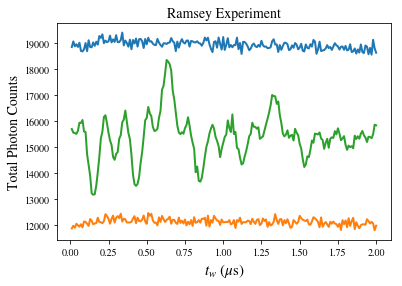

In [12]:
fig = plt.figure()
plt.plot(ramsey_times, np.sum(ramsey_data,axis=0), lw=2)
plt.xlabel(r'$t_w$ $(\mu $s$)$', size=15)
plt.ylabel('Total Photon Counts')
plt.title('Ramsey Experiment')

export_figure(fig, 'ramsey_raw_data')

Overwriting ../fig/rabi_raw_data_fft.png
Overwriting ../fig/rabi_raw_data_fft.pdf


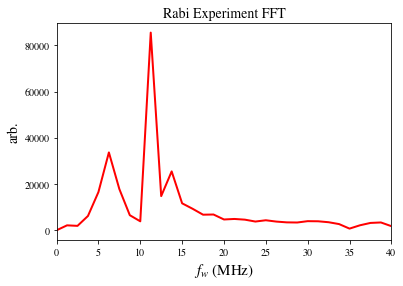

In [13]:
freqs = np.fft.fftshift(np.fft.fftfreq(n_rabi, rabi_times[1]-rabi_times[2]))
rabi_fft = np.abs(np.fft.fftshift(np.fft.fft(np.sum(rabi_data[:,:,2],axis=0)-np.mean(np.sum(rabi_data[:,:,2],axis=0),axis=0))))

fig = plt.figure()
plt.plot(freqs, np.abs(rabi_fft), lw=2, c='r')
plt.xlim([0,40])
plt.xlabel(r'$f_w$ (MHz)', size=15)
plt.ylabel('arb.')
plt.title('Rabi Experiment FFT')

export_figure(fig, 'rabi_raw_data_fft')

Overwriting ../fig/ramsey_raw_data_fft.png
Overwriting ../fig/ramsey_raw_data_fft.pdf


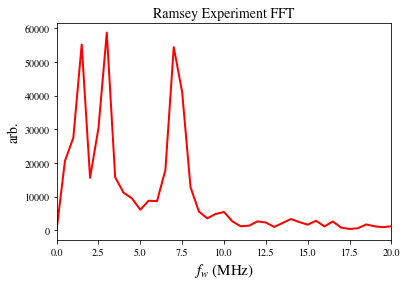

In [14]:
freqs = np.fft.fftshift(np.fft.fftfreq(n_ramsey, ramsey_times[1]-ramsey_times[2]))
ramsey_fft = np.abs(np.fft.fftshift(np.fft.fft(np.sum(ramsey_data[:,:,2],axis=0)-np.mean(np.sum(ramsey_data[:,:,2],axis=0),axis=0))))

fig = plt.figure()
plt.plot(freqs, np.abs(ramsey_fft),lw=2,c='r')
plt.xlim([0,20])
plt.xlabel(r'$f_w$ (MHz)', size=15)
plt.ylabel('arb.')
plt.title('Ramsey Experiment FFT')

export_figure(fig, 'ramsey_raw_data_fft')

Test the peak finding function

[ 7.   3.   1.5]


(0, 20)

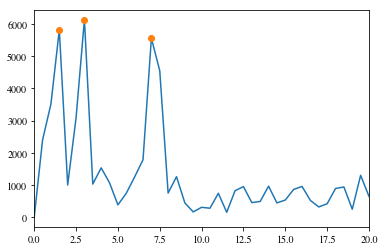

In [15]:
freqs = np.fft.fftshift(np.fft.fftfreq(n_ramsey, ramsey_times[1]-ramsey_times[2]))
ramsey_fft = np.abs(np.fft.fftshift(np.fft.fft(ramsey_data[8,:,2]-np.mean(ramsey_data[8,:,2]))))
peak_ind = m.detect_peaks(ramsey_fft[freqs>0],2000)
print freqs[freqs>0][peak_ind]
plt.plot(freqs, np.abs(ramsey_fft))
plt.plot(freqs[freqs>0][peak_ind],ramsey_fft[peak_ind],'o')
plt.xlim([0,20])

We see that the scatter plot of the reference plots is much different for Rabi and Ramsey; run on different days of the week.

Overwriting ../fig/rabi_ramsey_ref_scatter.png
Overwriting ../fig/rabi_ramsey_ref_scatter.pdf


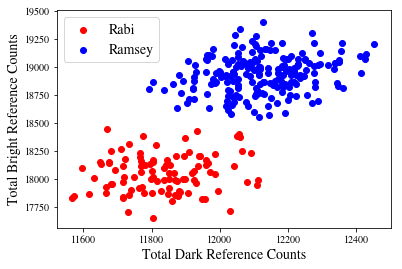

In [16]:
fig = plt.figure()
plt.scatter(np.sum(rabi_dark_refs,axis=0),np.sum(rabi_bright_refs,axis=0),color='r',label='Rabi')
plt.scatter(np.sum(ramsey_dark_refs,axis=0),np.sum(ramsey_bright_refs,axis=0),color='b',label='Ramsey')
plt.xlabel('Total Dark Reference Counts')
plt.ylabel('Total Bright Reference Counts')
plt.legend(loc=2)

export_figure(fig, 'rabi_ramsey_ref_scatter')

### Initialize QInfer Models

The QInfer models we will use for inference

In [17]:
ham_model = RabiRamseyModel()
ref_model = ReferencedPoissonModel(ham_model) 

model = qi.DirectViewParallelizedModel(ref_model, dview, serial_threshold=1) if parallel else ref_model

### Construct Priors and Reference Posteriors

#### Model Parameter Prior

Model parameters:
   - 0: :math:`\Omega`, Rabi strength (MHz); coefficient of Sx
   - 1: :math:`\omega_e`, Zeeman frequency (MHz); coefficient of Sz
   - 2: :math:`\Delta \omega_c`, ZFS detuning (MHz); coefficient of Sz^2
   - 3: :math:`\A_N`, Nitrogen hyperfine splitting (MHz); modeled as incoherent average  
   - 4: :math:`T_2^-1`, inverse of electron T2* (MHz)
   - 5: :math:`\Omega_\text{Ramsey}`, the Rabi strength (MHz) while doing a Ramsey experiment

Experiment parameters:
 - mode: Specifies whether a reference or signal count is being performed.
 - t:   Pulse width
 - tau: Ramsey wait time (only relevent if mode is `RabiRamseyModel.RAMSEY`)
 - phi: Ramsey phase between pulses (")

In [18]:
model_prior = qi.UniformDistribution(np.array([
            [0,10],
            [0,10],
            [-5,5],
            [1.5,3.5],
            [100**-1,1**-1],
            [0,0]
        ]))

#### Reference Prior

Use an empirical Bayes prior for the references for each batch. The variations in this empirical distribution are coming across experiment types. We allow a multplication to the variance to make the prior less informative than the empirical distribution. Use a different prior depending on whether it is Rabi or Ramsey.

In [19]:
# reference means and covariances for each batch
rabi_ref_mean = np.mean(np.stack((rabi_bright_refs, rabi_dark_refs),axis=0),axis=2).T
rabi_ref_cov = np.array([np.cov(x) for x in np.stack((rabi_bright_refs, rabi_dark_refs),axis=0).transpose((1,0,2))])
ramsey_ref_mean = np.mean(np.stack((ramsey_bright_refs, ramsey_dark_refs),axis=0),axis=2).T
ramsey_ref_cov = np.array([np.cov(x) for x in np.stack((ramsey_bright_refs, ramsey_dark_refs),axis=0).transpose((1,0,2))])

# reference means and covariances for the entire dataset
rabi_ref_single_mean = np.mean(np.sum(np.stack((rabi_bright_refs, rabi_dark_refs), axis=0), axis=1), axis=1)
rabi_ref_single_cov = np.cov(np.sum(np.stack((rabi_bright_refs, rabi_dark_refs), axis=0), axis=1))
ramsey_ref_single_mean = np.mean(np.sum(np.stack((ramsey_bright_refs, ramsey_dark_refs), axis=0), axis=1), axis=1)
ramsey_ref_single_cov = np.cov(np.sum(np.stack((ramsey_bright_refs, ramsey_dark_refs), axis=0), axis=1))

# empirical priors for each batch
def ref_prior(idx_batch, emode, var_mult=1):
    if emode == RabiRamseyModel.RABI:
        return qi.ProductDistribution(
            qi.GammaDistribution(mean=rabi_ref_mean[idx_batch,0], var=var_mult * rabi_ref_cov[idx_batch,0,0]),
            qi.GammaDistribution(mean=rabi_ref_mean[idx_batch,1], var=var_mult * rabi_ref_cov[idx_batch,1,1])
        )
    else:
        return qi.ProductDistribution(
            qi.GammaDistribution(mean=ramsey_ref_mean[idx_batch,0], var=var_mult * ramsey_ref_cov[idx_batch,0,0]),
            qi.GammaDistribution(mean=ramsey_ref_mean[idx_batch,1], var=var_mult * ramsey_ref_cov[idx_batch,1,1])
        )
    
# empirical priors for entire dataset
def ref_single_prior(emode, var_mult=1):
    if emode == RabiRamseyModel.RABI:
        return qi.ProductDistribution(
            qi.GammaDistribution(mean=rabi_ref_single_mean[0], var=var_mult * rabi_ref_single_cov[0,0]),
            qi.GammaDistribution(mean=rabi_ref_single_mean[1], var=var_mult * rabi_ref_single_cov[1,1])
        )
    else:
        return qi.ProductDistribution(
            qi.GammaDistribution(mean=ramsey_ref_single_mean[0], var=var_mult * ramsey_ref_single_cov[0,0]),
            qi.GammaDistribution(mean=ramsey_ref_single_mean[1], var=var_mult * ramsey_ref_single_cov[1,1])
        )
    
def plot_ref_dist(dist, **kwargs):
    test_samples = dist.sample(1000)
    plt.scatter(test_samples[:,1],test_samples[:,0],**kwargs)

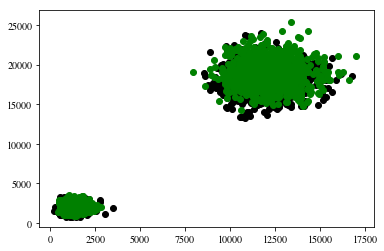

In [20]:
plot_ref_dist(ref_prior(8,RabiRamseyModel.RABI,var_mult=100), color='k')
plot_ref_dist(ref_prior(8,RabiRamseyModel.RAMSEY,var_mult=100),color='green')

plot_ref_dist(ref_single_prior(RabiRamseyModel.RABI,var_mult=100), color='k')
plot_ref_dist(ref_single_prior(RabiRamseyModel.RAMSEY,var_mult=100),color='green')

#### Uncorrelated Posterior

This function returns the product gamma posterior of the reference distribution given reference counts `x` and `y`. This is easy to compute when the prior is just a product of Gammas. 

In [21]:
# posterior for each batch
def ref_uncorr_posterior(x, y, emode, idx_batch, var_mult=1, data_divider=1):
    ref_mean, ref_cov = (rabi_ref_mean, rabi_ref_cov)  \
        if emode == RabiRamseyModel.RABI else (ramsey_ref_mean, ramsey_ref_cov)
    mu_b, mu_d = ref_mean[idx_batch, 0] / data_divider, ref_mean[idx_batch, 1] / data_divider
    var_b, var_d = var_mult * ref_cov[idx_batch, 0,0] / data_divider, var_mult * ref_cov[idx_batch, 1,1] / data_divider
        
    # use the conjugate prior update rule for gamma/poisson
    return qi.ProductDistribution(
        qi.GammaDistribution(alpha=x/data_divider + mu_b**2 / var_b, beta=1 + mu_b / var_b),
        qi.GammaDistribution(alpha=y/data_divider + mu_d**2 / var_d, beta=1 + mu_d / var_d)
    )

# posteriors for entire dataset
def ref_single_uncorr_posterior(x, y, emode, var_mult=1, data_divider=1):
    ref_mean, ref_cov = (rabi_ref_single_mean, rabi_ref_single_cov) \
        if emode == RabiRamseyModel.RABI else (ramsey_ref_single_mean, ramsey_ref_single_cov)
    mu_b, mu_d = ref_mean[0] / data_divider, ref_mean[1] / data_divider
    var_b, var_d = var_mult * ref_cov[0,0] / data_divider, var_mult * ref_cov[1,1] / data_divider
        
    # use the conjugate prior update rule for gamma/poisson
    return qi.ProductDistribution(
        qi.GammaDistribution(alpha=x / data_divider + mu_b**2 / var_b, beta=1 + mu_b / var_b),
        qi.GammaDistribution(alpha=y / data_divider + mu_d**2 / var_d, beta=1 + mu_d / var_d)
    )

#### Correlated Posterior

This function also returns a posterior for the reference distribution, as above, except under the slightly more complicated bivariate poisson model discussed in the appendix of the paper. We did not see significant improvement using this (technically better) posterior, at least in our reference count regime.

In [22]:
def ref_corr_posterior_weights(x, y, a0, b0, a1, b1, a2, b2, thresh=1e-2):
   
    def posgammaln(v):
        return gammaln(np.maximum(0,v))
    
    # we need to be quite careful about overflow; work in log space
    k = np.arange(np.min([x,y]))
    w = gammaln(k + a0) + posgammaln(x-k+a1) + posgammaln(y-k+a2) \
        + xlogy(k, (1+b1)*(1+b2)/(1+b0)) - gammaln(k+1) \
        - posgammaln(x-k+1) - posgammaln(y-k+1)
    w = w - logsumexp(w)
    w = np.exp(w)
    
    if thresh is not None:
        # in this case we get rid of w values which are too small
        mask = w > np.max(w)*thresh
        return k[mask], w[mask]
    else:
        return k, w

class BivariatePoissonPriorTerm(qi.Distribution):
    def __init__(self, a0, b0, a1, b1, a2, b2):
        self._dist = qi.ProductDistribution(
            qi.GammaDistribution(alpha=a0, beta=b0),
            qi.GammaDistribution(alpha=a1, beta=b1),
            qi.GammaDistribution(alpha=a2, beta=b2),
        )
    @property
    def n_rvs(self):
        return 2
    def sample(self, n=1):
        samples = self._dist.sample(n)
        return np.vstack([samples[:,0]+samples[:,1], samples[:,0]+samples[:,2]]).T
    

def ref_corr_posterior_generic(x, y, ref_mean, ref_cov, var_mult=1, thresh=1e-2):
    
    mu_b, mu_d = ref_mean[0], ref_mean[1]
    var_b, var_d, cov = var_mult*ref_cov[0,0], var_mult*ref_cov[1,1], ref_cov[0,1]
    a0, b0 = cov, 1
    a1, b1 = (mu_b-cov)**2 / (var_b-cov), (mu_b-cov) / (var_b-cov)
    a2, b2 = (mu_d-cov)**2 / (var_d-cov), (mu_d-cov) / (var_d-cov)
    
    k, w = ref_corr_posterior_weights(x, y, a0, b0, a1, b1, a2, b2, thresh=thresh)
    
    a0 = a0 + k
    a1 = a1 + x - k
    a2 = a2 + y - k
    o = np.ones(k.size)
    b0, b1, b2 = b0 + o, b1 + o, b2 + o
    
    return qi.MixtureDistribution(w, BivariatePoissonPriorTerm, dist_args=np.vstack([a0,b0,a1,b1,a2,b2]).T)

def ref_corr_posterior(x, y, emode, idx_batch, var_mult=1, thresh=1e-2):
    ref_mean, ref_cov = (rabi_ref_mean[idx_batch,...], rabi_ref_cov[idx_batch,...])  \
        if emode == RabiRamseyModel.RABI else (ramsey_ref_mean[idx_batch,...], ramsey_ref_cov[idx_batch,...])
    return ref_corr_posterior_generic(x, y, ref_mean, ref_cov, var_mult=var_mult, thresh=thresh)

def ref_single_corr_posterior(x, y, emode, var_mult=1, thresh=1e-2):
    ref_mean, ref_cov = (rabi_ref_single_mean, rabi_ref_single_cov) \
        if emode == RabiRamseyModel.RABI else (ramsey_ref_single_mean, ramsey_ref_single_cov)
    return ref_corr_posterior_generic(x, y, ref_mean, ref_cov, var_mult=var_mult, thresh=thresh)

#### Comparison Plots

In this section we make a bunch of plots as sanity checks for the above priors and posteriors. It would be really easy to write "rabi" instead of "ramsey" somewhere, for example.

First look at the empirical distribution (over experiments) of some batch, along with samples drawn from the corresponding prior.

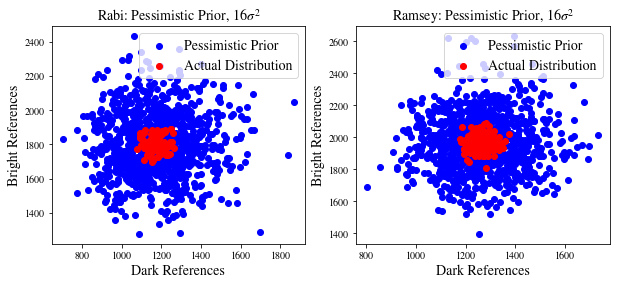

In [23]:
idx_batch = 8

fig = plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plot_ref_dist(ref_prior(idx_batch, RabiRamseyModel.RABI, var_mult=16), color='b', label='Pessimistic Prior')
plt.scatter(rabi_dark_refs[idx_batch,:], rabi_bright_refs[idx_batch,:], color='r', label='Actual Distribution')
plt.xlabel('Dark References')
plt.ylabel('Bright References')
plt.title(r'Rabi: Pessimistic Prior, $16\sigma^2$')
plt.legend(loc=1)

plt.subplot(1,2,2)
plot_ref_dist(ref_prior(idx_batch, RabiRamseyModel.RAMSEY, var_mult=16), color='b', label='Pessimistic Prior')
plt.scatter(ramsey_dark_refs[idx_batch,:], ramsey_bright_refs[idx_batch,:], color='r', label='Actual Distribution')
plt.xlabel('Dark References')
plt.ylabel('Bright References')
plt.title(r'Ramsey: Pessimistic Prior, $16\sigma^2$')
plt.legend(loc=1)

Same, but with the prior over the summed up data.

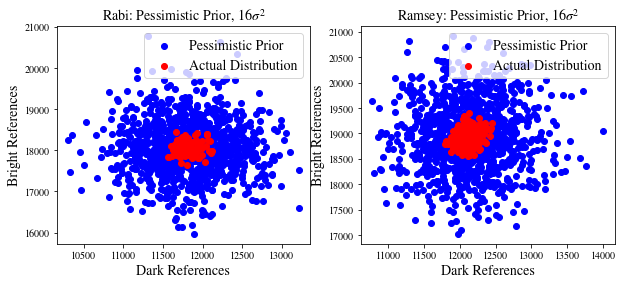

In [24]:
fig = plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plot_ref_dist(ref_single_prior(RabiRamseyModel.RABI, var_mult=16), color='b', label='Pessimistic Prior')
plt.scatter(np.sum(rabi_dark_refs, axis=0), np.sum(rabi_bright_refs, axis=0), color='r', label='Actual Distribution')
plt.xlabel('Dark References')
plt.ylabel('Bright References')
plt.title(r'Rabi: Pessimistic Prior, $16\sigma^2$')
plt.legend(loc=1)

plt.subplot(1,2,2)
plot_ref_dist(ref_single_prior(RabiRamseyModel.RAMSEY, var_mult=16), color='b', label='Pessimistic Prior')
plt.scatter(np.sum(ramsey_dark_refs, axis=0), np.sum(ramsey_bright_refs, axis=0), color='r', label='Actual Distribution')
plt.xlabel('Dark References')
plt.ylabel('Bright References')
plt.title(r'Ramsey: Pessimistic Prior, $16\sigma^2$')
plt.legend(loc=1)

Now look at the posteriors for batch 5 and experiment configuration 50

Overwriting ../fig/ref-posterior-comparison.png
Overwriting ../fig/ref-posterior-comparison.pdf


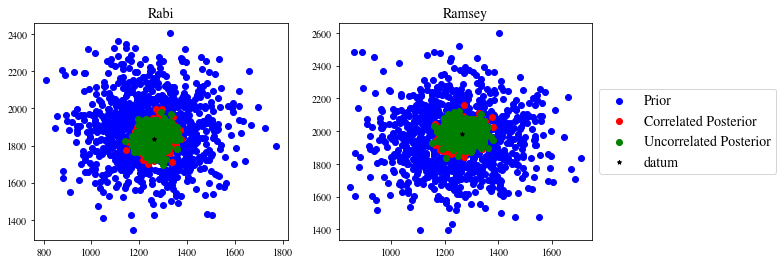

In [25]:
idx_batch = 5
idx_eps = 50

fig = plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plot_ref_dist(ref_prior(idx_batch, RabiRamseyModel.RABI, var_mult=16),color='b',label='Prior')
x, y = rabi_bright_refs[idx_batch,idx_eps],rabi_dark_refs[idx_batch,idx_eps]
plot_ref_dist(ref_corr_posterior(x,y,RabiRamseyModel.RABI,idx_batch,var_mult=16),color='r',label='Correlated Posterior')
plot_ref_dist(ref_uncorr_posterior(x,y,RabiRamseyModel.RABI,idx_batch,var_mult=16),color='g',label='Uncorrelated Posterior')

plt.scatter(y,x,marker='*',color='k', label='datum', s=16)
plt.title('Rabi')

plt.subplot(1,2,2)
plot_ref_dist(ref_prior(idx_batch, RabiRamseyModel.RAMSEY, var_mult=16),color='b',label='Prior')
x, y = ramsey_bright_refs[idx_batch,idx_eps],ramsey_dark_refs[idx_batch,idx_eps]
plot_ref_dist(ref_corr_posterior(x,y,RabiRamseyModel.RAMSEY,idx_batch,var_mult=16),color='r',label='Correlated Posterior')
plot_ref_dist(ref_uncorr_posterior(x,y,RabiRamseyModel.RAMSEY,idx_batch,var_mult=16),color='g',label='Uncorrelated Posterior')

plt.scatter(y,x,marker='*',color='k', label='datum', s=16)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Ramsey')

export_figure(fig, 'ref-posterior-comparison')

Finally, the same thing with the summed data

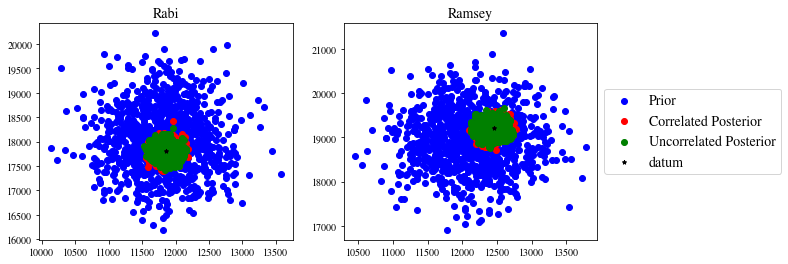

In [26]:
idx_eps = 50

fig = plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plot_ref_dist(ref_single_prior(RabiRamseyModel.RABI, var_mult=16),color='b',label='Prior')
x, y = np.sum(rabi_bright_refs[:,idx_eps]), np.sum(rabi_dark_refs[:,idx_eps])
plot_ref_dist(ref_single_corr_posterior(x,y,RabiRamseyModel.RABI,var_mult=16),color='r',label='Correlated Posterior')
plot_ref_dist(ref_single_uncorr_posterior(x,y,RabiRamseyModel.RABI,var_mult=16),color='g',label='Uncorrelated Posterior')

plt.scatter(y,x,marker='*',color='k', label='datum', s=16)
plt.title('Rabi')

plt.subplot(1,2,2)
plot_ref_dist(ref_single_prior(RabiRamseyModel.RAMSEY, var_mult=16),color='b',label='Prior')
x, y = np.sum(ramsey_bright_refs[:,idx_eps]), np.sum(ramsey_dark_refs[:,idx_eps])
plot_ref_dist(ref_single_corr_posterior(x,y,RabiRamseyModel.RAMSEY,var_mult=16),color='r',label='Correlated Posterior')
plot_ref_dist(ref_single_uncorr_posterior(x,y,RabiRamseyModel.RAMSEY,var_mult=16),color='g',label='Uncorrelated Posterior')

plt.scatter(y,x,marker='*',color='k', label='datum', s=16)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Ramsey')

For fun, see what happens if you accidentally use the prior of a single batch but enter the summed data. I definitely wasn't doing this for multiple months.

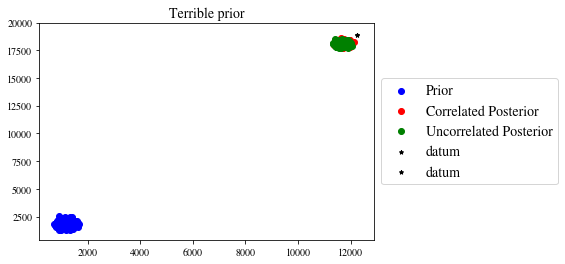

In [27]:
idx_batch = 2
idx_eps = 34

plot_ref_dist(ref_prior(idx_batch, RabiRamseyModel.RAMSEY, var_mult=16),color='b',label='Prior')
x, y = np.sum(ramsey_bright_refs[:,idx_eps]), np.sum(ramsey_dark_refs[:,idx_eps])
plot_ref_dist(ref_corr_posterior(x,y,RabiRamseyModel.RAMSEY,idx_batch,var_mult=16),color='r',label='Correlated Posterior')
plot_ref_dist(ref_uncorr_posterior(x,y,RabiRamseyModel.RAMSEY,idx_batch,var_mult=16),color='g',label='Uncorrelated Posterior')
plt.scatter(y,x,marker='*',color='k', label='datum', s=16)

plt.scatter(y,x,marker='*',color='k', label='datum', s=16)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Terrible prior')

#### Total Prior

Combine the Hamiltonian parameter prior with the reference prior. Note the reference prior doesn't really matter since we will be updating those priors manually with the conjugate posterior.

In [28]:
prior = qi.ProductDistribution(model_prior, ref_prior(0,0))

### Construct exparams and outcomes arrays

In this section we do the tedious but important task of shuffling the rabi and Ramsey experiment data together. Rerun these cells whenever you want a new order for `expparams` and `outcomes`.

In [29]:
idxs_data = np.empty(n_rabi+n_ramsey, dtype=int)
emodes = np.concatenate([RabiRamseyModel.RAMSEY * np.ones(n_ramsey),
                         RabiRamseyModel.RABI * np.ones(n_rabi)])
np.random.shuffle(emodes)
idxs_data[emodes.astype(bool)] = np.arange(n_ramsey)
idxs_data[(np.logical_not(emodes)).astype(bool)] = np.arange(n_rabi)

In [30]:
def make_expparam():
    for idx_exp in range(n_rabi + n_ramsey):
        idx_data = idxs_data[idx_exp]
        emode = emodes[idx_exp]
        mode = ref_model.SIGNAL
        if emode == RabiRamseyModel.RAMSEY:
            t = exp_data['RAMSEY']['t_pulse'] * 1e6
            tau = ramsey_times[idx_data]
            phi = 0
        else:
            t = rabi_times[idx_data]
            tau = 0
            phi = 0
        yield np.array([(t, tau, phi, emode, mode)], dtype=model.expparams_dtype)
def get_outcomes(idx_batch):
    for idx_exp in range(n_rabi + n_ramsey):
        idx_data = idxs_data[idx_exp]
        emode = emodes[idx_exp]
        if emode == RabiRamseyModel.RAMSEY:
            outcome = ramsey_data[idx_batch, idx_data, :]
        else:
            outcome = rabi_data[idx_batch, idx_data, :]
        yield outcome
expparams = list(make_expparam())
outcomes = np.array([np.array(list(get_outcomes(idx_batch))) for idx_batch in range(n_batch)])


### Test Model and Updater

#### Test Model Simulator

Final test of our QInfer model before the inference begins: make sure it generate sensible looking data when given a list of "true" model parameter values.

In [31]:
true_value = np.array([[6, 1.5, 0, 2.1, 10**-1, 6, 2400, 1400]])
sim_data = np.mean(ref_model.simulate_experiment(true_value, np.array(expparams).flatten(),repeat=10)[:,0,:],axis=0)

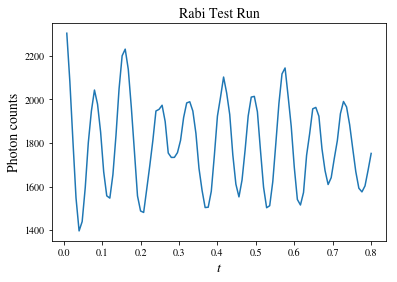

In [32]:
plt.plot(rabi_times, sim_data[emodes==0])
plt.title('Rabi Test Run')
plt.xlabel('$t~(\mu s)$')
plt.ylabel('Photon counts')

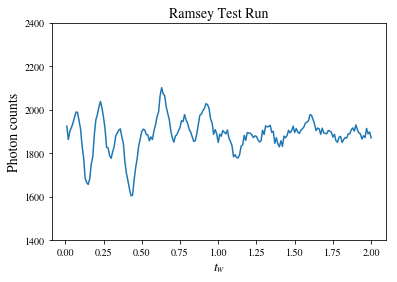

In [33]:
plt.plot(ramsey_times, sim_data[emodes==1])
plt.ylim([1400,2400])
plt.title('Ramsey Test Run')
plt.xlabel('$t_w~(\mu s)$')
plt.ylabel('Photon counts')

[ 7.  3.  1.]


(0, 20)

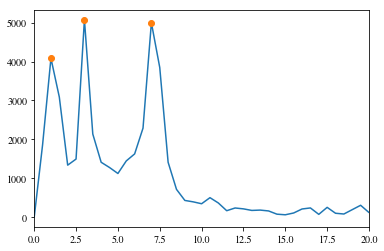

In [34]:
freqs = np.fft.fftshift(np.fft.fftfreq(n_ramsey, ramsey_times[1]-ramsey_times[2]))
sim_ramsey_fft = np.abs(np.fft.fftshift(np.fft.fft(sim_data[emodes==1]-np.mean(sim_data[emodes==1]))))
peak_ind = m.detect_peaks(sim_ramsey_fft[freqs>0],3000)
print freqs[freqs>0][peak_ind]
plt.plot(freqs, np.abs(sim_ramsey_fft))
plt.plot(freqs[freqs>0][peak_ind],sim_ramsey_fft[peak_ind],'o')
plt.xlim([0,20])

#### Test our custom updater

Set up one updater that is forced to bridge into 8 updates, another that doesn't bridge at all, and one that bridges with many branches. We look at (a marginal of) the posterior in both cases to check that they are the same. We are basically making sure the code doesn't have bugs, we know this works in theory. We turn off resampling for a fair plot comparison, acknowledging however, the whole point of bridging is to allow resampling in between so that the effective particle size never drops too much. Note the steady decrease in effective particles over the 8 updates. They are about the same speed to run because of memoization.

7.899509 1834
9.939295 [[[5491, 3815], [3067, 2627]], [[2330, 2113], [1947, 1815]]]
22.934723 [[13385, 11429, 10123, 9144, 8374, 7751, 7235, 6801, 6429, 6107], [5825, 5575, 5352, 5152, 4970, 4805, 4655, 4516, 4389, 4270], [4161, 4058, 3963, 3873, 3789, 3710, 3635, 3564, 3497, 3434], [3373, 3316, 3261, 3209, 3159, 3111, 3065, 3022, 2979, 2939], [2900, 2863, 2827, 2792, 2758, 2726, 2694, 2664, 2635, 2606], [2579, 2552, 2526, 2501, 2477, 2453, 2430, 2408, 2386, 2365], [2344, 2324, 2304, 2285, 2266, 2248, 2230, 2213, 2196, 2179], [2163, 2147, 2131, 2116, 2101, 2087, 2072, 2058, 2045, 2031], [2018, 2005, 1992, 1980, 1967, 1955, 1944, 1932, 1921, 1909], [1898, 1888, 1877, 1866, 1856, 1846, 1836, 1826, 1816, 1807]]
8.506822 1793


/Users/ihincks/miniconda2/envs/nvmeas/lib/python2.7/site-packages/QInfer-1.0-py2.7.egg/qinfer/utils.py:271: ApproximationWarning: Numerical error in covariance estimation causing positive semidefinite violation.


34.195731 [[[5526, 8838], [6601, 10055]], [[7776, 11014], [8774, 7494]]]
55.835569 [[13410, 11461, 10150, 9160, 8377, 7741, 15124, 13986, 12992, 12149], [11429, 10808, 10267, 9791, 9368, 8990, 8650, 8341, 8061, 7804], [15412, 14596, 13843, 13175, 12586, 12063, 11596, 11175, 10795, 10448], [10130, 9838, 9567, 9317, 9083, 8865, 8661, 8469, 8288, 8117], [7956, 15573, 14930, 14306, 13736, 13219, 12752, 12328, 11942, 11588], [11262, 10962, 10683, 10424, 10182, 9955, 9742, 9542, 9354, 9175], [9006, 8846, 8694, 8549, 8410, 8278, 8152, 8031, 7915, 15687], [15190, 14687, 14212, 13771, 13363, 12987, 12638, 12313, 12011, 11728], [11464, 11215, 10981, 10760, 10552, 10354, 10167, 9988, 9819, 9657], [9503, 9355, 9214, 9079, 8949, 8825, 8705, 8590, 8479, 8372]]
Overwriting ../fig/qhl-bridge-transitions.png
Overwriting ../fig/qhl-bridge-transitions.pdf


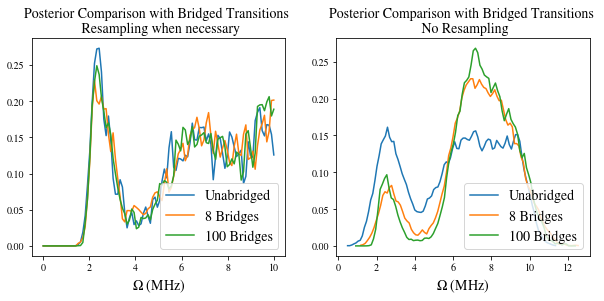

In [35]:
fig = plt.figure(figsize=(10,4))
for idx, check_for_resample in enumerate([False, True]):

    updater1 = m.BridgedRPMUpdater(model, 16000, prior, n_ess_thresh=1)
    updater2 = m.BridgedRPMUpdater(model, 16000, prior, n_ess_thresh=16000, max_recursion=3)
    updater3 = m.BridgedRPMUpdater(model, 16000, prior, n_ess_thresh=16000, max_recursion=2, branch_size=10)

    var_mult = 16
    save_marginal_pics = True

    # pick an arbitrary experiment to update with
    idx_exp = 42
    ep = expparams[idx_exp]

    # unbatch data by summing over the batch index
    x,y,z = np.sum(outcomes[:, idx_exp], axis=0)

    # define function that updates alpha and beta indices
    def ref_updater(updater, x, y):
        posterior = ref_single_uncorr_posterior(x, y, emodes[idx_exp], var_mult=var_mult)
        updater.particle_locations[:,-2:] = posterior.sample(updater.n_particles)

    # do the update on each updater
    for u in [updater1, updater2, updater3]:
        t1 = datetime.now()
        ref_updater(u, x, y)
        n_ess = u.update(z, ep, check_for_resample=check_for_resample)
        dt = datetime.now() - t1
        print dt.total_seconds(), n_ess

    plt.subplot(1,2,idx+1)
    updater1.plot_posterior_marginal()
    updater2.plot_posterior_marginal()
    updater3.plot_posterior_marginal()
    plt.legend(['Unabridged', '8 Bridges', '100 Bridges'],loc=4)
    plt.xlabel('$\Omega$ (MHz)')

    if check_for_resample:
        plt.title('Posterior Comparison with Bridged Transitions \n No Resampling')
    else:
        plt.title('Posterior Comparison with Bridged Transitions \n Resampling when necessary')
        
export_figure(fig, 'qhl-bridge-transitions')

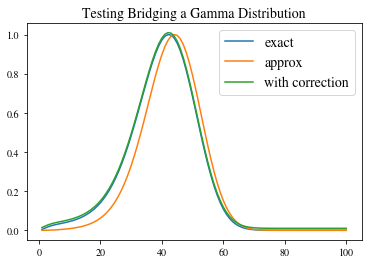

In [36]:
def gamma_pdf(x, mean, sigma):
    a, b = (mean / sigma) **2, mean / sigma **2
    return np.exp(xlogy(a, b) + xlogy(a-1, x) - b * x - gammaln(a))

def normalize(v):
    return v / np.max(v)

x = 40
mean = np.linspace(1,100,100)
sigma = 10
a, b = (mean / sigma) **2, mean / sigma **2
plt.plot(mean, normalize(gamma_pdf(x, mean, sigma)), label='exact')
plt.plot(mean, normalize(gamma_pdf(x/2, mean/2, sigma/np.sqrt(2)) * gamma_pdf(x/2, mean/2, sigma/np.sqrt(2))),label='approx')

correction = np.exp(gammaln(a/2) + xlogy(a, 2)/2  - gammaln(a)/2)
plt.plot(mean, 0.01 + normalize(correction **2 * gamma_pdf(x/2, mean/2, sigma/np.sqrt(2)) * gamma_pdf(x/2, mean/2, sigma/np.sqrt(2))),label='with correction')

plt.legend()
plt.title('Testing Bridging a Gamma Distribution')

#### Test how many engines to use

We do some tests to see how well likelihood evaluation does on varying numbers of CPU cores. We have found that using all physical cores (and not hyperthreaded cores), or maybe just a couple of hyperthreaded cores, is best.

In [37]:
do_par_test = True
if parallel and do_par_test:
    
    test_n_particles = 20000
    
    def compute_L(model):
        model.likelihood(outcomes[0,:10,2],prior.sample(n=test_n_particles),np.array(expparams[0]).flatten()[:10])
        
    serial_time = %timeit -q -o -n1 -r1 compute_L(ref_model)
    serial_time = serial_time.all_runs[0]
    
    n_engines = np.arange(2,len(dview)+1,2)
    par_time = np.zeros(n_engines.shape[0])
    
    for idx_ne, ne in enumerate(n_engines):
        dview_test = rc[:ne]
        dview_test.use_dill()
        dview_test.execute('os.chdir("{}")'.format(os.getcwd()))
        dview_test.execute('import os')
        dview_test.execute('import qinfer as qi')
        dview_test.execute('import models')
        model_test = qi.DirectViewParallelizedModel(ref_model, dview_test, serial_threshold=1)

        result = %timeit -q -o -n1 -r1 compute_L(model_test)
        par_time[idx_ne] = result.all_runs[0]
    

Overwriting ../fig/parallel-likelihood-test.png
Overwriting ../fig/parallel-likelihood-test.pdf


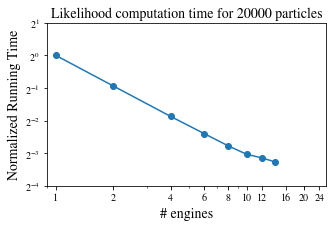

In [38]:
if parallel and do_par_test:
    
    fig = plt.figure(y)
    fig.set_figheight(3)
    fig.set_figwidth(5)
    ax = fig.add_subplot(111)
    
    y_data = np.concatenate([[serial_time], par_time])/serial_time
    x_data = np.concatenate([[1], n_engines])
    
    plt.plot(x_data, y_data,'-o')
    plt.xlabel('# engines')
    plt.ylabel('Normalized Running Time')
    plt.title('Likelihood computation time for {} particles'.format(test_n_particles))
    plt.ylim([2**(-4),2^0])
    plt.xlim([0.9,26])
    ax.set_yscale('log', basey=2)
    ax.set_xscale('log', basey=2)
    ax.set_xticks([1,2,4,6,8,10,12,16,20,24])
    ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

    export_figure(fig, 'parallel-likelihood-test')

### Process Data

#### Plotting function for video

In [39]:
def plot_marginals(updater, covs):
    """
    """
    fig = plt.figure(figsize=(12,7))
    ranges = [[0,10], [0,10], [-5,5], [1.5,3.5], [100**-1,1**-1], [0,0]]
    
    plt.subplot(2,3,6)
    stop = np.nonzero(covs[:,0,0] == 0)[0]
    stop = stop[0] if len(stop) > 0 else covs.shape[0]
    plt.plot(np.log10(np.sqrt(np.diagonal(covs[:stop,:-3,:-3],axis1=1,axis2=2))),lw=2,linestyle='-')
    leg = plt.legend(["${}$".format(x) for x in ham_model.modelparam_names[:-1]],
               bbox_to_anchor=(0., 0, 1., .102), loc=3, ncol=5, mode="expand", borderaxespad=0.)
    for txt in leg.get_texts():
        txt.set_ha("center")
        txt.set_x(-25)
        txt.set_y(2)
    colors = []
    for line in leg.get_lines():
        line.set_ydata(line.get_ydata()-10) # y-position
        colors.append(line.get_color())
        
    plt.xlabel(r'# experiments included in estimate')
    plt.title(r'$\log_{10}(\mathrm{std}[\cdot]/\mathrm{MHz})$')
    plt.ylim([-6,1])
    plt.xlim([0,300])
    
    for idx, idx_param in enumerate([1,2,0,3,4]):
        plt.subplot(2,3,idx_param+1)
        updater.plot_posterior_marginal(
            idx_param,
            range_min=ranges[idx_param][0],
            range_max=ranges[idx_param][1],
            smoothing=0.0003,
            other_plot_args={'lw':1.5,'color':colors[idx]}
        )
        plt.ylim(bottom=0)
        plt.gca().set_yticklabels([])
        #plt.ylabel('$\Pr({})$'.format(ham_model.modelparam_names[idx_param]))
        plt.title('$\Pr[{}$ (MHz)$]$'.format(ham_model.modelparam_names[idx_param]))
        plt.xlabel('')
    plt.tight_layout()
    return fig

#### Run Inference on summed data

In [40]:
single_updater = m.BridgedRPMUpdater(model, 16000, prior, n_ess_thresh=2000)
single_means = np.zeros((n_rabi+n_ramsey, model.n_modelparams))
single_covs = np.zeros((n_rabi+n_ramsey, model.n_modelparams, model.n_modelparams))

var_mult = 16
save_marginal_pics = True

for idx_exp in range(n_rabi+n_ramsey):
    
    if save_marginal_pics: # make a video
        fig = plot_marginals(single_updater, single_covs)
        fig.savefig('../fig/video/posterior{0:03d}.png'.format(idx_exp))
        plt.close(fig)
    
    ep = expparams[idx_exp]
    # unbatch data by summing over the batch index
    x,y,z = np.sum(outcomes[:, idx_exp], axis=0)
    # update the posterior
    posterior = ref_single_uncorr_posterior(x, y, emodes[idx_exp], var_mult=var_mult)
    single_updater.particle_locations[:,-2:] = posterior.sample(single_updater.n_particles)
    t1 = datetime.now()
    n_ess = single_updater.update(z, ep)
    dt = datetime.now() - t1
    print ep, dt.total_seconds(), int(single_updater.min_n_ess), n_ess
        
    # record the first two moments for later plotting
    single_means[idx_exp,:] = single_updater.est_mean()
    single_covs[idx_exp,:,:] = single_updater.est_covariance_mtx()
    
    if np.mod(idx_exp+1, 50) == 0:
        print idx_exp, single_updater.est_mean()[:5]

[( 0.008,  0.,  0., 0, 0)] 3.704145 3776 3776
[( 0.016,  0.,  0., 0, 0)] 3.380578 3564 3564
[( 0.044,  0.01,  0., 1, 0)] 6.135045 3326 3326
[( 0.024,  0.,  0., 0, 0)] 3.690415 3326 9277
[( 0.032,  0.,  0., 0, 0)] 3.910432 3326 3703
[( 0.04,  0.,  0., 0, 0)] 7.802549 2657 [[4493, 8786], 2657]
[( 0.044,  0.02,  0., 1, 0)] 5.69577 2657 6442
[( 0.048,  0.,  0., 0, 0)] 3.71889 2657 4289
[( 0.056,  0.,  0., 0, 0)] 11.491201 2657 [[4510, 6452], 4531]
[( 0.044,  0.03,  0., 1, 0)] 6.479943 2657 7158
[( 0.044,  0.04,  0., 1, 0)] 6.623493 2657 7955
[( 0.044,  0.05,  0., 1, 0)] 6.599187 2657 3067
[( 0.064,  0.,  0., 0, 0)] 3.773386 2657 5139
[( 0.044,  0.06,  0., 1, 0)] 6.329747 2657 6120
[( 0.072,  0.,  0., 0, 0)] 3.749101 2657 11807
[( 0.044,  0.07,  0., 1, 0)] 6.225421 2657 6228
[( 0.044,  0.08,  0., 1, 0)] 6.416244 2657 5271
[( 0.08,  0.,  0., 0, 0)] 3.690355 2657 7597
[( 0.088,  0.,  0., 0, 0)] 3.755403 2657 9478
[( 0.096,  0.,  0., 0, 0)] 3.795975 2657 7839
[( 0.044,  0.09,  0., 1, 0)] 6.346

[( 0.044,  1.11,  0., 1, 0)] 8.085451 2031 11134
[( 0.044,  1.12,  0., 1, 0)] 16.572403 2031 [5152, 8531]
[( 0.044,  1.13,  0., 1, 0)] 8.034984 2031 4352
[( 0.456,  0.,  0., 0, 0)] 3.761202 2031 13280
[( 0.044,  1.14,  0., 1, 0)] 8.213537 2031 3958
[( 0.044,  1.15,  0., 1, 0)] 8.284246 2031 7930
[( 0.464,  0.,  0., 0, 0)] 3.822345 2031 7636
[( 0.044,  1.16,  0., 1, 0)] 8.077025 2031 12346
[( 0.044,  1.17,  0., 1, 0)] 7.945879 2031 9397
[( 0.044,  1.18,  0., 1, 0)] 7.908346 2031 8376
[( 0.472,  0.,  0., 0, 0)] 3.874185 2031 7569
[( 0.044,  1.19,  0., 1, 0)] 8.053454 2031 14821
[( 0.044,  1.2,  0., 1, 0)] 7.985328 2031 6053
[( 0.044,  1.21,  0., 1, 0)] 8.008932 2031 10997
[( 0.48,  0.,  0., 0, 0)] 7.629415 2031 [5141, 7465]
[( 0.044,  1.22,  0., 1, 0)] 7.972157 2031 11081
[( 0.044,  1.23,  0., 1, 0)] 8.003841 2031 10446
[( 0.044,  1.24,  0., 1, 0)] 8.180593 2031 7419
[( 0.488,  0.,  0., 0, 0)] 7.715458 2031 [4455, 4444]
[( 0.044,  1.25,  0., 1, 0)] 7.950124 2031 11291
[( 0.496,  0.,  0.,

Overwriting ../fig/qhl-two-param-marginals.png
Overwriting ../fig/qhl-two-param-marginals.pdf


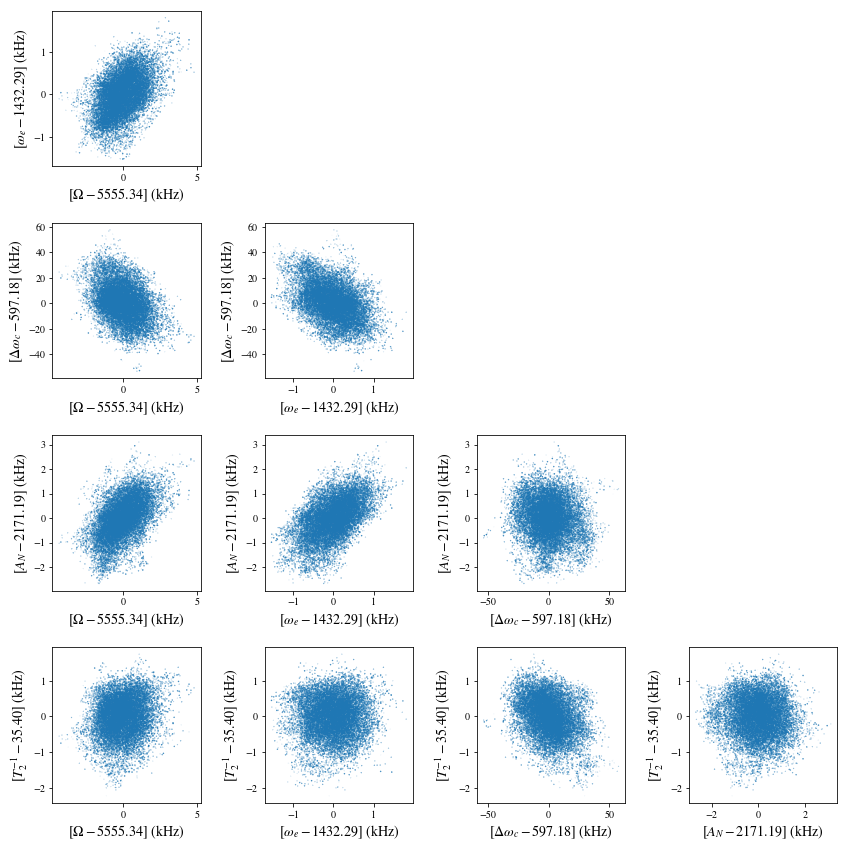

In [41]:
fig = plt.figure(figsize=(12,12))
plt_count = 0
plt_units = ["kHz"] * 5
# bah subplot indexing is too confusing to automate
for x_param, y_param, plt_count in [(0,1,1),  (0,2,5),(1,2,6),  (0,3,9),(1,3,10),(2,3,11), (0,4,13),(1,4,14),(2,4,15),(3,4,16)]:
    plt.subplot(5-1,5-1,plt_count)
    #plt.contour(
    #    *single_updater.posterior_mesh(idx_param1=x_param, idx_param2=y_param, res1=10, res2=10, smoothing=0.0002)
    #)
    mean_x = np.sum(single_updater.particle_weights * single_updater.particle_locations[:,x_param])
    mean_y = np.sum(single_updater.particle_weights * single_updater.particle_locations[:,y_param])
    plt.scatter(
        1e3 * (single_updater.particle_locations[:,x_param]-mean_x),
        1e3 * (single_updater.particle_locations[:,y_param]-mean_y),
        s = single_updater.particle_weights * 1000
    )
    plt.xlabel(r'$[{0}-{1:.2f}]$ ({2})'.format(model.modelparam_names[x_param], 1000 * mean_x, plt_units[x_param]))
    plt.ylabel(r'$[{0}-{1:.2f}]$ ({2})'.format(model.modelparam_names[y_param], 1000 * mean_y, plt_units[y_param]))

plt.tight_layout()
    
export_figure(fig, 'qhl-two-param-marginals')

Overwriting ../fig/../fig/qhl-param-uncertainty.png
Overwriting ../fig/../fig/qhl-param-uncertainty.pdf


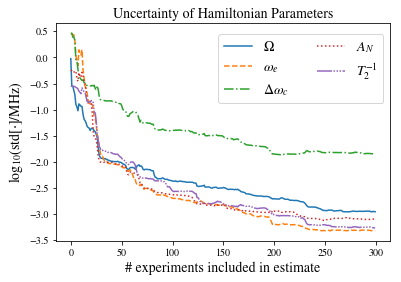

In [49]:
fig = plt.figure()
lines = plt.plot(np.log10(np.sqrt(np.diagonal(single_covs[:,:-3,:-3],axis1=1,axis2=2))))
for style, line in zip(["-","--","-.",":","--"], lines):
    line.set_linestyle(style)
lines[-1].set_dashes([10,1,1,1,1,1,1,1])
plt.legend(["${}$".format(x) for x in model.modelparam_names[:-3]],
    ncol=2,
    bbox_to_anchor=(0., 0.6, 1., 0.0)
)
plt.xlabel(r'# experiments included in estimate')
plt.ylabel(r'$\log_{10}(\mathrm{std}[\cdot]/\mathrm{MHz})$')
plt.title('Uncertainty of Hamiltonian Parameters')

export_figure(fig, '../fig/qhl-param-uncertainty')

Overwriting ../fig/qhl-param-estimates.png
Overwriting ../fig/qhl-param-estimates.pdf


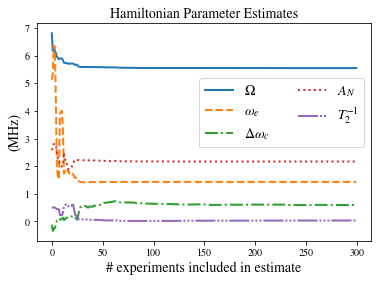

In [66]:
fig = plt.figure()
lines = plt.plot(single_means[:,:-3], lw=2)
for style, line in zip(["-","--","-.",":","--"], lines):
    line.set_linestyle(style)
lines[-1].set_dashes([10,1,1,1,1,1,1,1])
plt.legend(["${}$".format(x) for x in model.modelparam_names[:-3]],
    ncol=2,
    bbox_to_anchor=(0., 0.7, 1., 0.08)
)

plt.xlabel(r'# experiments included in estimate')
plt.ylabel(r'(MHz)')
plt.title('Hamiltonian Parameter Estimates')

export_figure(fig, 'qhl-param-estimates')

#### Run Inference on each batch

Now we run the inference engine on each of the ten batches separately. On our 12 core setup, this takes about 15 mins per batch.

In [51]:
updaters = [None] * n_batch
track_means = np.zeros((n_batch, n_rabi+n_ramsey, model.n_modelparams))
track_covs = np.zeros((n_batch, n_rabi+n_ramsey, model.n_modelparams, model.n_modelparams))

var_mult = 16

for idx_batch in range(10):
    print "  "
    print "--------------------" 
    print "Starting batch {} at {}...".format(idx_batch, datetime.now())
    print "--------------------"
    updaters[idx_batch] = m.BridgedRPMUpdater(model, 8000, prior, n_ess_thresh=1000)

    for idx_exp in range(n_rabi+n_ramsey):
        ep = expparams[idx_exp]
        
        x,y,z = outcomes[idx_batch, idx_exp]
        # update the posterior
        posterior = ref_uncorr_posterior(x, y, emodes[idx_exp], idx_batch, var_mult=var_mult)
        updaters[idx_batch].particle_locations[:,-2:] = posterior.sample(updaters[idx_batch].n_particles)
        updaters[idx_batch].update(z, ep)
        
        track_means[idx_batch, idx_exp,:] = updaters[idx_batch].est_mean()
        track_covs[idx_batch, idx_exp,:,:] = updaters[idx_batch].est_covariance_mtx()
        if np.mod(idx_exp+1, 50) == 0:
            print idx_exp, updaters[idx_batch].est_mean()[:5], updaters[idx_batch].min_n_ess

  
--------------------
Starting batch 0 at 2017-05-20 17:12:01.232833...
--------------------
49 [ 5.63052271  1.268664    0.77540209  2.38089834  0.1664124 ] 1052.34456113
99 [ 5.53758295  1.43667779  0.90000977  2.17506075  0.0205459 ] 1052.34456113
149 [ 5.51845569  1.4444177   0.90252977  2.1603798   0.02550541] 1042.71969405
199 [ 5.55095083  1.43131574  0.58837846  2.17832174  0.03949048] 1042.71969405
249 [ 5.55199295  1.43458457  0.72796959  2.17880065  0.04442842] 1042.71969405
299 [ 5.55445137  1.4297501   0.63796809  2.18115614  0.04386573] 1042.71969405
  
--------------------
Starting batch 1 at 2017-05-20 17:29:38.504543...
--------------------
49 [ 5.62779455  1.40154668  0.31832559  2.1998285   0.12421823] 1366.975659
99 [ 5.54089841  1.44033301  0.12879095  2.1835262   0.02066476] 1228.5309446
149 [ 5.56326083  1.41405612 -0.18945448  2.18737433  0.03184686] 1085.56245533
199 [ 5.56944051  1.42347726 -0.5667385   2.17721174  0.0323375 ] 1085.56245533
249 [ 5.55669414 

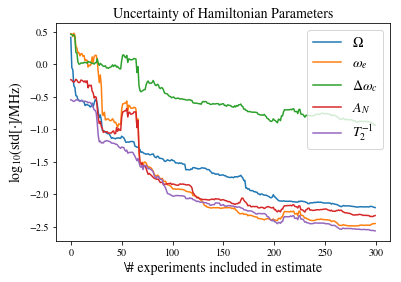

In [52]:
fig = plt.figure()
plt.plot(np.log10(np.sqrt(np.diagonal(track_covs[0,:,:-3,:-3],axis1=1,axis2=2))))
plt.legend(["${}$".format(x) for x in model.modelparam_names[:-3]])
plt.xlabel(r'\# experiments included in estimate')
plt.ylabel(r'$\log_{10}(\mathrm{std}[\cdot]/\mathrm{MHz})$')
plt.title('Uncertainty of Hamiltonian Parameters')

#fig.savefig('../fig/ham-param-uncertainty.pdf')

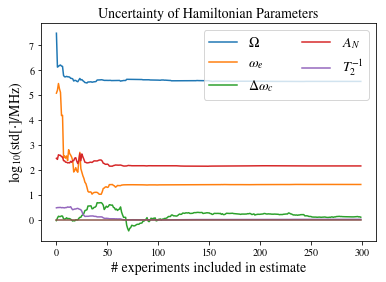

In [53]:
fig = plt.figure()
plt.plot(track_means[5,:,:-2])
plt.legend(["${}$".format(x) for x in model.modelparam_names[:-3]],ncol=2)
plt.xlabel(r'# experiments included in estimate')
plt.ylabel(r'$\log_{10}(\mathrm{std}[\cdot]/\mathrm{MHz})$')
plt.title('Uncertainty of Hamiltonian Parameters')

In [54]:
def in_ellipse(x, A, c):
    y = c[np.newaxis,:] - x
    return np.einsum('ij,jl,il->i', y, np.linalg.inv(A), y) <= 1
def cv(percentage, axes = np.s_[0:1]):
    n_axes = updaters[0].est_mean()[axes].shape[0]
    ests = np.array([u.est_mean() for u in updaters])
    result = []
    for idx_u, u in enumerate(updaters):
        A = u.est_covariance_mtx()[axes, axes]
        c = u.est_mean()[axes]
        result += [np.array([
            1 if idx_u == idx_u2 else \
                in_ellipse(
                    u2.particle_locations[:,axes],
                    (chi2.ppf(percentage, n_axes)) * A, 
                    c
                ).sum() / u2.n_particles
            for idx_u2, u2 in enumerate(updaters)
        ]).mean()]
    return np.array(result) * 100

for idx_u, u in enumerate(updaters):
    if not single_updater.just_resampled:
        print "Resampling {}".format(idx_u)
        u.resample()

ps = np.linspace(0.1, 1, 20)

fig=plt.figure()
#plt.plot(ps, map(cv, ps))

cv(0.99)

Resampling 0
Resampling 1
Resampling 2
Resampling 3
Resampling 4
Resampling 5
Resampling 6
Resampling 7
Resampling 8
Resampling 9


/Users/ihincks/miniconda2/envs/nvmeas/lib/python2.7/site-packages/QInfer-1.0-py2.7.egg/qinfer/smc.py:512: ResamplerWarning: Resampling without additional data; this may not perform as desired.


array([ 83.1925 ,  97.72625,  93.1575 ,  83.47125,  96.06625,  93.72   ,
        84.245  ,  99.405  ,  77.43625,  91.465  ])

### Simulate with estimate

In this section, we take posterior estimates and use them to simulate the experiments as a kind of posterior predictive check.

In [55]:
def sim_rabi(est):
    sim = ham_model.likelihood([0],est[np.newaxis,:-2], np.array(expparams).flatten())[0,0,:]
    return sim[emodes==0]
def sim_ramsey(est):
    sim = ham_model.likelihood([0],est[np.newaxis,:-2], np.array(expparams).flatten())[0,0,:]
    return sim[emodes==1]

In [56]:
def est_error_bars(confidence, p, alpha, beta):
    return np.sqrt(2) * erfinv(confidence) * np.sqrt(p*(p+1)*alpha + (p-1)*(p-2)*beta)/(alpha-beta)
def est_std(p, alpha, beta):
    return np.sqrt(p*(p+1)*alpha + (p-1)*(p-2)*beta)/(alpha-beta)

Overwriting ../fig/qhl-rabi-fit.png
Overwriting ../fig/qhl-rabi-fit.pdf


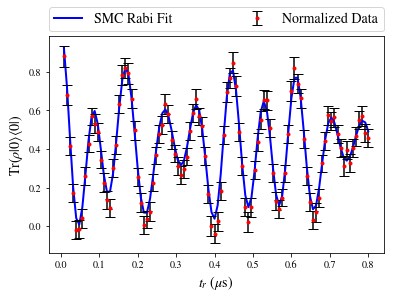

In [57]:
p_rabi = np.sum(rabi_data[:,:,2]-rabi_data[:,:,1].astype(float),axis=0)/np.sum(rabi_data[:,:,0]-rabi_data[:,:,1],axis=0)
p_ramsey = np.sum(ramsey_data[:,:,2]-ramsey_data[:,:,1].astype(float),axis=0)/np.sum(ramsey_data[:,:,0]-ramsey_data[:,:,1],axis=0)

rabi_error_bars = est_error_bars(0.95, p_rabi, np.sum(rabi_bright_refs,axis=0), np.sum(rabi_dark_refs,axis=0))
ramsey_error_bars = est_error_bars(0.95, p_ramsey, np.sum(ramsey_bright_refs,axis=0), np.sum(ramsey_dark_refs,axis=0))

fig = plt.figure()

plt.plot(rabi_times, sim_rabi(single_updater.est_mean()),color='b',lw=2,label='SMC Rabi Fit')
plt.errorbar(rabi_times, p_rabi, yerr=rabi_error_bars, color='red', ls='', marker='o', markersize=3, capsize=5, capthick=1, ecolor='black', label='Normalized Data')

plt.ylabel(r'Tr$(\rho |0\rangle\langle 0|)$')
plt.xlabel(r'$t_r$ ($\mu$s)')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)

export_figure(fig, 'qhl-rabi-fit')

Overwriting ../fig/qhl-ramsey-fit.png
Overwriting ../fig/qhl-ramsey-fit.pdf


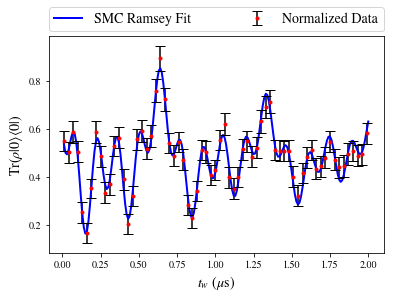

In [58]:
p_rabi = np.sum(rabi_data[:,:,2]-rabi_data[:,:,1].astype(float),axis=0)/np.sum(rabi_data[:,:,0]-rabi_data[:,:,1],axis=0)
p_ramsey = np.sum(ramsey_data[:,:,2]-ramsey_data[:,:,1].astype(float),axis=0)/np.sum(ramsey_data[:,:,0]-ramsey_data[:,:,1],axis=0)

rabi_error_bars = est_error_bars(0.95, p_rabi, np.sum(rabi_bright_refs,axis=0), np.sum(rabi_dark_refs,axis=0))
ramsey_error_bars = est_error_bars(0.95, p_ramsey, np.sum(ramsey_bright_refs,axis=0), np.sum(ramsey_dark_refs,axis=0))

fig = plt.figure()

plt.plot(ramsey_times, sim_ramsey(single_updater.est_mean()),color='b',lw=2, label='SMC Ramsey Fit')
plt.errorbar(ramsey_times[::3], p_ramsey[::3], yerr=ramsey_error_bars[::3], color='red', ls='', marker='o', markersize=3, capsize=5, capthick=1, ecolor='black', label='Normalized Data')

plt.ylabel(r'Tr$(\rho |0\rangle\langle 0|)$')
plt.xlabel(r'$t_w$ ($\mu$s)')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)

export_figure(fig, 'qhl-ramsey-fit')

Overwriting ../fig/qhl-batch-fits.png
Overwriting ../fig/qhl-batch-fits.pdf


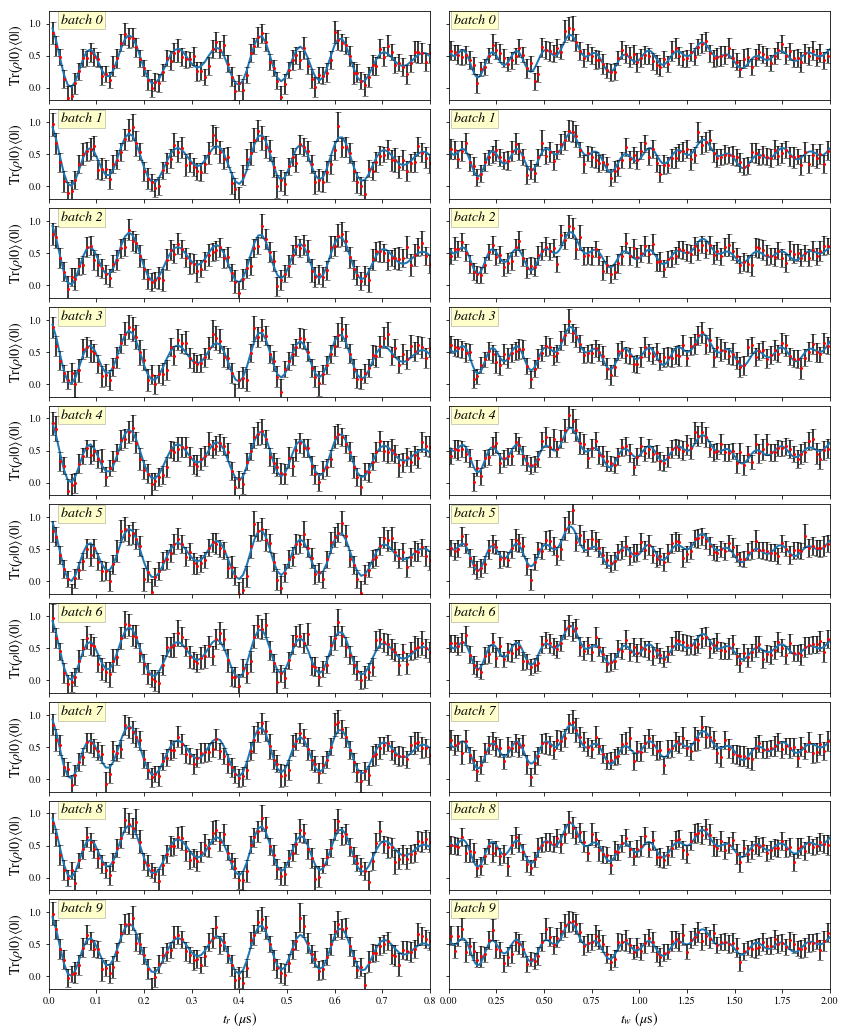

In [59]:
fig, axes = plt.subplots(10,2,sharex=False,sharey=True,figsize=(14,18))
    
for idx_batch in range(n_batch):
    
    p_rabi = (rabi_data[idx_batch,:,2]-rabi_data[idx_batch,:,1].astype(float))/(rabi_data[idx_batch,:,0]-rabi_data[idx_batch,:,1])
    p_ramsey = (ramsey_data[idx_batch,:,2]-ramsey_data[idx_batch,:,1].astype(float))/(ramsey_data[idx_batch,:,0]-ramsey_data[idx_batch,:,1])

    rabi_error_bars = est_error_bars(0.95, p_rabi, rabi_bright_refs[idx_batch,:], rabi_dark_refs[idx_batch,:])
    ramsey_error_bars = est_error_bars(0.95, p_ramsey, ramsey_bright_refs[idx_batch,:], ramsey_dark_refs[idx_batch,:])
    
    axes[idx_batch][0].plot(rabi_times, sim_rabi(updaters[idx_batch].est_mean()),lw=2,label='SMC Rabi Fit')
    axes[idx_batch][0].errorbar(rabi_times, p_rabi, yerr=rabi_error_bars, color='red', ls='', marker='o', markersize=2, capsize=3, capthick=0.5, ecolor='black', label='Normalized Data')

    axes[idx_batch][0].set_ylim([-0.2,1.2])
    axes[idx_batch][0].set_xlim([0,0.8])
    axes[idx_batch][0].set_ylabel(r'Tr$(\rho |0\rangle\langle 0|)$')
    if idx_batch >= 9:
        axes[idx_batch][0].set_xlabel(r'$t_r$ ($\mu$s)')
    else:
        axes[idx_batch][0].xaxis.set_ticklabels([])
    axes[idx_batch][0].text(0.025, 1, 'batch {}'.format(idx_batch), style='italic',
        bbox={'facecolor':'yellow', 'alpha':0.2, 'pad':3})
    
    
    axes[idx_batch][1].plot(ramsey_times, sim_ramsey(updaters[idx_batch].est_mean()),lw=2,label='SMC Ramsey Fit')
    axes[idx_batch][1].errorbar(ramsey_times[::2], p_ramsey[::2], yerr=ramsey_error_bars[::2], color='red', ls='', marker='o', markersize=2, capsize=3, capthick=0.5, ecolor='black', label='Normalized Data')

    #plt.ylabel(r'Tr$(\rho |0\rangle\langle 0|)$')
    axes[idx_batch][1].set_ylim([-0.2,1.2])
    axes[idx_batch][1].set_xlim([0,2])
    if idx_batch >= 9:
        axes[idx_batch][1].set_xlabel(r'$t_w$ ($\mu$s)')
    else:
        axes[idx_batch][1].xaxis.set_ticklabels([])
    axes[idx_batch][1].text(0.025, 1, 'batch {}'.format(idx_batch), style='italic',
        bbox={'facecolor':'yellow', 'alpha':0.2, 'pad':3})
 
fig.subplots_adjust(hspace=0.1,wspace=0.05)


export_figure(fig, 'qhl-batch-fits')

### Least Square Fits

Finally, we run WLSF on each of the batches and compare to SMC.

In [60]:
def fit_fcn(X, Omega, we, dwc, an, T2i):
    # this function simulates experiment type k at time t with the given parameters
    ks, ts = X
    out = np.empty(len(ks))
    # might as well do a loop since it is much easier than dealing with expparams,
    # and ham_model would just do a loop to
    for idx_exp in range(len(ks)):
        k, t = ks[idx_exp], ts[idx_exp]
        if k == ham_model.RABI:
            sim = ham_model.likelihood(
                [0],
                np.array([[Omega, we, dwc, an, T2i, 0]]),
                np.array([(t,0,0,ham_model.RABI)], dtype=ham_model.expparams_dtype)
            )
        if k == ham_model.RAMSEY:
            sim = ham_model.likelihood(
                [0],
                np.array([[Omega, we, dwc, an, T2i, 0]]),
                np.array([(0.044,t,0,ham_model.RAMSEY)], dtype=ham_model.expparams_dtype)
            )
        out[idx_exp] = sim.flatten()[0]
    return out

First do least squares on the entire dataset:

In [61]:
p_rabi = np.sum(rabi_data[:,:,2]-rabi_data[:,:,1].astype(float),axis=0)/np.sum(rabi_data[:,:,0]-rabi_data[:,:,1],axis=0)
p_ramsey = np.sum(ramsey_data[:,:,2]-ramsey_data[:,:,1].astype(float),axis=0)/np.sum(ramsey_data[:,:,0]-ramsey_data[:,:,1],axis=0)

rabi_error_bars = est_std(p_rabi, np.sum(rabi_bright_refs,axis=0), np.sum(rabi_dark_refs,axis=0))
ramsey_error_bars = est_std(p_ramsey, np.sum(ramsey_bright_refs,axis=0), np.sum(ramsey_dark_refs,axis=0))

xdata = np.concatenate([
        np.vstack([np.ones(rabi_times.size)*ham_model.RABI, rabi_times]).T,
        np.vstack([np.ones(ramsey_times.size)*ham_model.RAMSEY, ramsey_times]).T
    ]).T
ydata = np.concatenate([p_rabi, p_ramsey])
sigma = np.concatenate([rabi_error_bars, ramsey_error_bars])

popt_single, pcov_single = curve_fit(
    fit_fcn,
    xdata,
    ydata,
    single_updater.est_mean()[:-3],
    sigma,
    method='lm'
)

In [62]:
popts = np.empty((n_batch,5))
pcovs = np.empty((n_batch,5,5))
for idx_batch in range(n_batch):
    p_rabi = (rabi_data[idx_batch,:,2]-rabi_data[idx_batch,:,1].astype(float))/(rabi_data[idx_batch,:,0]-rabi_data[idx_batch,:,1])
    p_ramsey = (ramsey_data[idx_batch,:,2]-ramsey_data[idx_batch,:,1].astype(float))/(ramsey_data[idx_batch,:,0]-ramsey_data[idx_batch,:,1])

    rabi_error_bars = est_std(p_rabi, rabi_bright_refs[idx_batch,:], rabi_dark_refs[idx_batch,:])
    ramsey_error_bars = est_std(p_ramsey, ramsey_bright_refs[idx_batch,:], ramsey_dark_refs[idx_batch,:])

    xdata = np.concatenate([
            np.vstack([np.ones(rabi_times.size)*ham_model.RABI, rabi_times]).T,
            np.vstack([np.ones(ramsey_times.size)*ham_model.RAMSEY, ramsey_times]).T
        ]).T
    ydata = np.concatenate([p_rabi, p_ramsey])
    sigma = np.concatenate([rabi_error_bars, ramsey_error_bars])

    print "Starting {}...".format(idx_batch)
    
    popts[idx_batch,:], pcovs[idx_batch,:,:] = curve_fit(
        fit_fcn,
        xdata,
        ydata,
        updaters[idx_batch].est_mean()[:-3],
        sigma,
        method='lm'
    )

Starting 0...
Starting 1...
Starting 2...
Starting 3...
Starting 4...
Starting 5...
Starting 6...
Starting 7...
Starting 8...
Starting 9...


Overwriting ../fig/qhl-cv-field-posterior.png
Overwriting ../fig/qhl-cv-field-posterior.pdf


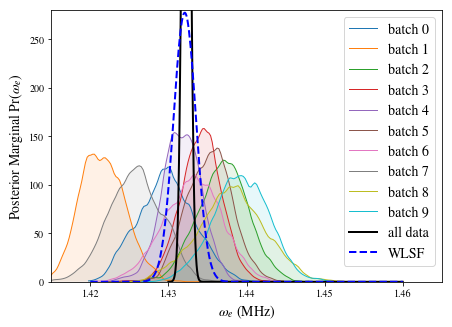

In [63]:
fig = plt.figure(figsize=(7,5))
ax = fig.gca()
for idx_u, u in enumerate(updaters):
    line = u.plot_posterior_marginal(1, smoothing=0.0003, other_plot_args={'label':"batch {}".format(idx_u),'lw':1})
    xs, ys = u.posterior_marginal(1, smoothing=0.0003)
    ax.fill_between(xs, 0, ys, facecolor=line[0].get_color(), alpha='0.1')


xs = np.linspace(1.43,1.46,400)
x_mean = single_updater.est_mean()[1]
x_var = single_updater.est_covariance_mtx()[1,1]
plt.plot(xs, np.exp(-(xs-x_mean)**2/(2*x_var))/(np.sqrt(2*np.pi*x_var)),'-',lw=2,c='k',label='all data')

xs = np.linspace(1.42,1.46,400)
x_mean = popt_single[1]
x_var = pcov_single[1,1]
plt.plot(xs, np.exp(-(xs-x_mean)**2/(2*x_var))/(np.sqrt(2*np.pi*x_var)),'--',lw=2,c='b',label='WLSF')

plt.xlim([1.415,1.465])
plt.ylim([0,280])
plt.ylabel('Posterior Marginal $\Pr(\omega_e)$')
plt.xlabel('$\omega_e$ (MHz)')
plt.legend(loc=1)

export_figure(fig, 'qhl-cv-field-posterior')

Overwriting ../fig/qhl-cv-rabi-posterior.png
Overwriting ../fig/qhl-cv-rabi-posterior.pdf


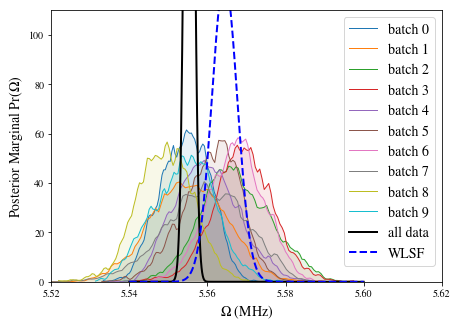

In [64]:
fig = plt.figure(figsize=(7,5))
ax = fig.gca()
for idx_u, u in enumerate(updaters):
    line = u.plot_posterior_marginal(0, smoothing=0.0003, other_plot_args={'label':"batch {}".format(idx_u),'lw':1})
    xs, ys = u.posterior_marginal(0, smoothing=0.0003)
    ax.fill_between(xs, 0, ys, facecolor=line[0].get_color(), alpha='0.1')
        
xs = np.linspace(5.54,5.6,400)
x_mean = single_updater.est_mean()[0]
x_var = single_updater.est_covariance_mtx()[0,0]
plt.plot(xs, np.exp(-(xs-x_mean)**2/(2*x_var))/(np.sqrt(2*np.pi*x_var)),lw=2,c='k',label='all data')

xs = np.linspace(5.54,5.6,400)
x_mean = popt_single[0]
x_var = pcov_single[0,0]
plt.plot(xs, np.exp(-(xs-x_mean)**2/(2*x_var))/(np.sqrt(2*np.pi*x_var)),'--',lw=2,c='b',label='WLSF')

plt.xlim([5.52, 5.62])
plt.ylim([0,110])
plt.ylabel('Posterior Marginal $\Pr(\Omega)$')
plt.xlabel('$\Omega$ (MHz)')
plt.legend(loc=1)

export_figure(fig, 'qhl-cv-rabi-posterior')

In [65]:
comparison_tex_table = ""
comparison_tex_table += "\\begin{tabularx}{0.85\\textwidth}{ll"
for k in range(5):
    comparison_tex_table += "XX"
comparison_tex_table += "}\n"

comparison_tex_table += "    ~ & ~"
table_names = ham_model.modelparam_names
table_names[2] = "\\delta\\Delta"
for idx_param in [1,2,0,3,4]:
    comparison_tex_table += " & \multicolumn{{2}}{{c}}{{${}$}}".format(table_names[idx_param])
comparison_tex_table += " \\\\ \n"

comparison_tex_table += "    ~ & ~"
for idx_param in range(5):
    comparison_tex_table += " & $\mathbb{E}$ & $\sigma$"
comparison_tex_table += " \\\\ \n"

def make_table_row(name, updater, popt, pcov):
    out = ""
    out += "    \\cline{3-12}\n"
    out += "    \\multirow{{2}}{{*}}{{{}\\quad}} & SMC~~~~ ".format(name)
    for idx_param in [1,2,0,3,4]:
        out += "& {0:.0f} & {1:.1f} ".format(
            1000*updater.est_mean()[idx_param], 
            1000*np.sqrt(updater.est_covariance_mtx()[idx_param,idx_param])
        )
    out += "\\\\ \n    & WLSF~~~~ "
    for idx_param in [1,2,0,3,4]:
        out += "& {0:.0f} & {1:.1f} ".format(
            1000*popt[idx_param], 
            1000*np.sqrt(pcov[idx_param,idx_param])
        )
    out += "\\\\ \n"
    return out
    
comparison_tex_table += make_table_row('all data', single_updater, popt_single, pcov_single)

for idx_batch in range(n_batch):
    comparison_tex_table += make_table_row(
        'batch {}'.format(idx_batch), 
        updaters[idx_batch], 
        popts[idx_batch,:], pcovs[idx_batch,:,:]
    )

comparison_tex_table += "    \\cline{3-12}\n"
comparison_tex_table += "\\end{tabularx}"

print "Writing comparison table to file..."
with open("../fig/qhl-results-tab.txt", "w") as text_file:
    text_file.write(comparison_tex_table)
print "Done."

Writing comparison table to file...
Done.
